In [91]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
def loadSimpleData():
    datMat = matrix([[1., 2.1],
                    [2., 1.1],
                    [1.3, 1.],
                    [1., 1.],
                    [2., 1.]])
    classLabels = matrix([1.0, 1.0, -1.0, -1.0, 1.0])
    
    return datMat, classLabels

In [93]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
        
    return retArray

def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClassEst = mat(zeros((m, 1)))
    minError = inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
        
    return bestStump, minError, bestClassEst

In [94]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m, 1)) / m)
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print("Total error:", errorRate)
        if errorRate == 0.0:
            break
        
    return weakClassArr, aggClassEst

In [95]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
    return sign(aggClassEst)

In [96]:
datArr, labelArr = loadSimpleData()
classifierArr, _ = adaBoostTrainDS(datArr, labelArr, 30)
adaClassify([0, 0], classifierArr)

Total error: 0.2
Total error: 0.2
Total error: 0.0


matrix([[-1.]])

## Horse Colic Dataset

In [97]:
def loadDataSet(filename):
    numFeat = len(open(filename).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [98]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [99]:
classifierArray, _ = adaBoostTrainDS(datArr, labelArr, 10)

Total error: 0.2842809364548495
Total error: 0.2842809364548495
Total error: 0.24749163879598662
Total error: 0.24749163879598662
Total error: 0.25418060200668896
Total error: 0.2408026755852843
Total error: 0.2408026755852843
Total error: 0.22073578595317725
Total error: 0.24749163879598662
Total error: 0.23076923076923078


In [100]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')

In [101]:
prediction10 = adaClassify(testArr, classifierArr)

In [102]:
errArr = mat(ones((67, 1)))
errArr[prediction10 != mat(testLabelArr).T].sum()

28.0

In [103]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    %matplotlib inline
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClass = sum(array(classLabels) == 1.0)
    yStep = 1 / float(numPosClass)
    xStep = 1 / float(len(classLabels) - numPosClass)
    sortedIndices = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndices.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("The area under the curve is: ", ySum * xStep)

In [104]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')

In [105]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)

Total error: 0.2842809364548495
Total error: 0.2842809364548495
Total error: 0.24749163879598662
Total error: 0.24749163879598662
Total error: 0.25418060200668896
Total error: 0.2408026755852843
Total error: 0.2408026755852843
Total error: 0.22073578595317725
Total error: 0.24749163879598662
Total error: 0.23076923076923078


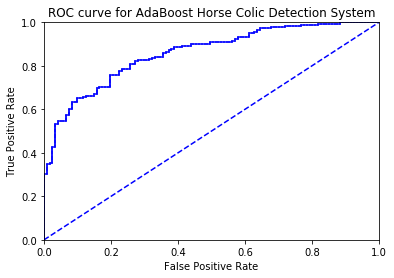

The area under the curve is:  0.8582969635063604


In [106]:
plotROC(aggClassEst.T, labelArr)